# Explaining explainable AI: understanding SHAP 


Explainable artificial intelligence (XAI, a.k.a interpretable machine learning) is a thing those days. The goal of XAI is to provide explanations for machine learning models predictions, such that humans can understand the reasons that lead to those predictions. 

It is important to know the reasons behind an algorithm's predictions in a variety of contexts: 
- when you have to explain to a bank customer why his loan was refused by an algorithm, 
- when you use your machine learning model as an advisor for critical decisions (e.g. in medicine), 
- when law requires you to be able to explain your model's predictions (like GDPR's "right to explanation"), 
- or when you want to check that your model has learned sound patterns and thus won't overfit the very day you'll release it in production. 


While some machine learning models are easily interpretable by nature, like the simple decision tree, the best perfoming ones are usually harder to fathom for a human being. Indeed, the winning solutions on the leading machine learning competitions website Kaggle always involve ensemble (e.g. gradient boosting model, random forest, ...) and deep learning models. Those two families of models produce predictions that are hard to interpret for humans. More generally, in most machine learning modelling situations there is a tradeoff between interpretability and performance. 


A method named [SHAP](<http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions>)  has made a lot of noise since its publication in 2017. At the time [LIME](<https://arxiv.org/abs/1602.04938>) was the rockstar of model interpretation methods. While the LIME original paper is fairly easy to understand and well explained by many blog articles, I haven't found a "SHAP for dummies" blog article with toy examples that demistifies this complex research paper succintly. Thus I've rolled up my sleeves, studied the article, and I'll try to share the essence of it with simple explanations in this article. 

## Why do we need another interpretation method?

Let's use a motivating example for the remainder of this article. Imagine you own a motorbike rental shop and try to understand the influence of advertising on your number of daily rentals. Your goal is to pay for ads only when it has an important leverage. You carefully keep track of the target variable (number of rentals) and three binary predictors: whether you paid to display your ad, if it was a weekday, and whether it was raining this day or not. Here is the dataset you've collected after a while:

| Rentals | Ad? | Weekday? | Rain? |
| ------- | --- | -------- | ----- |
| 10      | 1   | 1        | 1     |
| 8       | 0   | 1        | 0     |
| 20      | 1   | 0        | 0     |
| 12      | 0   | 1        | 0     |
| ...     | ... | ...      | ...   |

You've trained a fairly accurate machine learning model that predicts the number of rentals based on your three variables. 

How to know how effective was the ad on a specific day?

### Naive approach (and why it is bad)

If you want to understand the impact of adverstisement for your first example, you may simply compare the number of rentals predicted by your model with and without advertisment, i.e. compute the importance $\phi_a$ of the advertisement variable with the following formula:

$$ \phi_a = f \left(x_a=1, x_w=1, x_r=1\right) - f \left(x_a=0, x_w=1, x_r=1\right), $$

where $f$ is your machine learning model, and $x_a$, $x_w$, and $x_r$ are the Ad?, Weekday?, and Rain? variables respectively.

There are several problems with this approach:
- The virtual datapoint that we use to compare our prediction $\left(x_a=0, x_w=1, x_r=1\right)$ might not be realistic regarding the data generation process. In that case the model knows nothing about those datapoints and the prediction can be completely random. Note that SHAP - and most approaches in interpretable ML - do not completely solve this problem.
- This naive approach is bad at distributing importance among features when there are correlations. For instance if we add a "Schoolday" variable that is perfectly correlated with weekday (if we ignore holidays), the machine learning model might use only one of those two variable for its prediction. Still, we want to distribute the importance equally between those two correlated features!  
- There are several more desirable properties of explanation methods that are broken by this approach, as we'll see in the rest of this article.

If you know about ML interpretation you might want to use LIME, but the SHAP articles shows that the LIME method also breaks two interpretation methods desirable properties: consistency and local accuracy. 

## A natural and general explanation framework: feature attribution

SHAP, LIME, and many others belong to the family of [local interpretation methods](https://christophm.github.io/interpretable-ml-book/lime.html). Those methods approximate a complex ML model $f$ with a simpler one $g$ that produces similar results around the data points for which we want to explain the model prediction.

Local explanation methods also introduce the concept of *simplified inputs* (denoted with a prime) that ease interpretation: typically, simplified inputs are binary variables corresponding to the presence of features, words or pixels. Those simplified inputs can be (locally) mapped back to original inputs through a mapping function $h_x$. An example might help here: consider a sentiment analysis model that only predicts a 50 % probability for the sentence "I am happy" to correspond to positive sentiment. You have to understand why the probability is not larger.

Your input feature $x$ might be a complex embedding of the sentence (e.g. $x=(0.523, 8.35, ...)$), but you can define $x'$ such that  $x'=(1, 1, 1)$ corresponds to the presence of the three words "I", "am" and "happy". The mapping function $h_x$ can be any function that would map $x'=(1, 1, 1)$ to $x=(0.523, 8.35, ...)$. 

Local interpretation generate models $g$ that are locally similar to the original model, i.e. such that $g(z')\simeq f\left(h_x(z')\right)$ close to the data point under investigation.

From the interpretable model $g$, feature attribution consists in distributing the prediction outcome between the different variables:
$$ g(z') = \phi_0 + \sum_{i=0}^M \phi_i z_i'  $$
where $z_i \in \{0, 1\}$.

Going back to our "I am happy" example, $\phi_0$ would be the prediction in the complete absence of words, $\phi_0+\phi_1$ would be the local model prediction $g(1,0,0)$ for a virtual example with only the word "I", etc.

Now a question remains: what properties should we expect from feature attribution methods, and what method satisfies them?

## Shapley values: the most elegant and accurate feature attribution method

The theoretical elegance of the SHAP article comes from the fact that they have listed the desirable properties of additive feature attribution methods:

1. **Local accuracy**: the explanation model $g$ must give the same prediction has the original model for the untransformed input. This property implies  that the weight $\phi_i$ sum to the original model prediction $f(x)$, i.e. $\sum_i \phi_i = f(x)$.

2. **Missingness**: if a feature is missing the associated weight is 0. This property might seem odd at first. It is only relevant for a dataset with constant features, for which we want the constant feature to have no weight.

3. **Consistency**: if the effect of adding a feature $x_i$ is larger for a model $f'$ than for another model $f$, the corresponding weight $\phi_i$ must be larger for $f'$ than for $f$.

Note that LIME breaks the properties 1 and 3. Indeed, LIME fits the interpretable model $g$ to the original model for a set of points close to the original point $x$, thus you have no guarantee that it produces the same prediction at $x$, hence it does not necessarily respect local accuracy. Similarly, the fit process does not guarantee consistency.

The main result of the paper is its only theorem, which states that **the only possible set of weights satisfying the three properties above is given by the Shapley values.**

Note that the proof of the theorem relies on previous results and I won't delve on it here, but you can have a look at the article and the references therein if you want details. I will rather jump to the presentation of the Shapley values.

Shapley values are an old, slightly complex, and powerful concept. It comes from games theory as a method to distribute rewards between players in collaborative games. Here the feature values replace the players, and the goal is to determine how the feature values have "collaborated" to produce the model prediction (with possible negative contributions to the collaboration).

The Shapley value of a feature $i$ its average contribution in all possible coalitions ... 🧐This sibylline sentence is better explained with an example. This is going to get tricky but this is the core of the method, so bear with me!

Back to our motorbike rental example, imagine we have
- trained a model on the dataset above, 
- computed the prediction for a new data point $x=\left(x_a=1, x_w=1, x_r=0\right)$ and obtained $f(x)=12$
- we now want to know the influence of the "Ad?" feature for this prediction.

To compute the Shapley value of the "Ad?" feature for this example we list the coalitions involving "Ad?": 

- "Ad?" & "Weekday?" $\longrightarrow \{x_a, x_w\}$
- "Ad?" & "Rain?" $\longrightarrow \{x_a, x_r\}$
- "Ad?" & "Weekday?" & "Rain?" $\longrightarrow \{x_a, x_w, x_r\}$

For each coalition $S \in \left\{ \{x_a, x_w\}, \{x_a, x_r\}, \{x_a, x_w, x_r\}\right\}$ we compute the contribution of the $i$-th variable to the coalition as the prediction of the model trained with the complete coalition minus the prediction of the model trained without this variable (let's note the model trained with all variables in the coalition as $f_S$ to avoid confusion with the original model $f$)

$$\delta_{i}^{(S)} = f_S\left(S\right)-f_{S_-i}\left(S_{-i} \right), $$

where $S_{-i} = S \;\backslash\; \{x_i\}$ is the coalition **without** the variable $i$.

For instance the contribution of the feature $x_a$ to the coalition $\{x_a, x_r\}$ is 

$$ \delta_{x_a}^{\left\{x_a, x_r\right\}} = f_{\{x_a, x_r\}}\left(\{x_a, x_r\}\right)-f_{\{x_r\}}\left(\{x_r\}\right) .$$

The contribution of the variable $x_a$ is then obtained with the following formula:

$$\phi_{a}=\frac{1}{p} \sum_{S}\left(\begin{array}{c}{p-1} \\ {|S-1|}\end{array}\right)^{-1}\delta_{a}^{(S)},$$

where $p$ is the total number of features (3 here). Hence it is the weighted average of the different coalitions contributions, the weight is simply the number of ways you can choose partners in the coalition ($|S|-1$ variables among $p-1$).

Back to our example the formula for $\phi_a$ would read:

$$
\begin{align}
\phi_{a}& =\frac{1}{3} \sum_{S \in \left\{ \{x_a, x_w\}, \{x_a, x_r\}, \{x_a, x_w, x_r\}\right\}}\left(\begin{array}{c}{p-1} \\ {|S-1|}\end{array}\right)^{-1}\delta_{a}^{(S)}\\
& = \frac{1}{3} \left[
\left(\begin{array}{c}{2} \\ {1}\end{array}\right)^{-1}\delta_{a}^{\{x_a, x_w\}}+
\left(\begin{array}{c}{2} \\ {1}\end{array}\right)^{-1}\delta_{a}^{\{x_a, x_r\}}+
\left(\begin{array}{c}{2} \\ {2}\end{array}\right)^{-1}\delta_{a}^{\{x_a, x_w, x_r\}}
\right] \\
& = \dots \\
& = \frac{2}{3} \left[f_{\{x_a, x_r\}}\left(\{x_a, x_r\}\right)-f_{\{x_r\}}\left(\{x_r\}\right)
+ f_{\{x_a, x_w\}}\left(\{x_a, x_w\}\right)-f_{\{x_w\}}\left(\{x_w\}\right)
+ \frac12( f_{\{x_a, x_w, x_r\}}\left(\{x_a, x_w, x_r\}\right)-f_{\{x_w, x_r\}}\left(\{x_w, x_r\})\right)
\right]
\end{align} 
🙀
$$

That's a lot of terms to compute and models to train, six in total. Note that we have 3 features here, but since all features combinations are involved the number of models to be trained grows exponentially with the number of features. 

This is only tractable in exceptional situations, that is why the SHAP paper introduces methods to compute approximate Shapley values, without having to train this huge number of models.

## SHAP or the art of tractable estimations of Shapley values with Kernel SHAP

Several methods have been proposed to estimate Shapley values efficiently. The main problem is to estimate the models fit with subsets of features, and avoid computing terms for all possible coalitions. Some proposed methods are model-specific (to linear models, [tree-based models](https://arxiv.org/abs/1802.03888) and [neural networks](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)) and another one is generic but might be slower or provide worse estimations ([Kernel SHAP](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)).

I will only go through KernelSHAP because it is the most versatile version of SHAP. The interested reader can go through the references above.

The core idea of Kernel SHAP is the following: instead of retraining models with subsets of features, we can use the full model $f$ that is already trained, and replace "missing features" with "marginalized features" (i.e. missing features are "integrated out"), that are typically estimated with data samples. For instance with 3 features $x_1$, $x_2$, and $x_3$\, the partial models where $x_3$ is missing is estimated with the following formula:

$$ f_{\left\{x_1, x_2\right\}}\left(x_1, x_2\right) \xrightarrow[\text{Kernel SHAP}]{} \int f\left(x_1, x_2, x_3\right)  p(x_3) \mathrm d x_3$$

Estimating this quantity still requires a choice for $p(x_3)$. A naive sampling choice would lead to the use of unrealistic data points and would break the desired explanations properties mentioned above. 

The authors found a way to maintain those properties with the LIME method. Note that is doesn't mean that we have done all this work and ended up using plain LIME. Here LIME is used with a custom proximity function $\pi$ that is very different from LIME's:

$$ \pi_x^{\mathrm{LIME}}(z) = \exp (−D(x, z)^2/\sigma^2), $$ 

where $D$ is a distance function (typically the cartesian distance for structured data), 

$$ \pi_{x}^{\mathrm{SHAP}}\left(z^{\prime}\right)=\frac{(p-1)}{\left(\begin{array}{c}{p} \\ {\left|z^{\prime}\right|}\end{array}\right)\left|z^{\prime}\right|\left(p-\left|z^{\prime}\right|\right)},$$

where $p$ is the number of features.

These two equations are obviously very different, the first one uses the original features (masked, hence $z$ instead of $x$) and penalizes distances between sampled points and the original data point for which we seek an explanation. On the other hand, the SHAP similarity kernel only uses the **number** of features in the coalition $|z'|$ and it penalizes coalitions with a number of features that are far from $0$ or $p$. That is, it puts more weight on coalitions that are either using a small number of features (because it highlights the "independent" behavior of the features) or almost all of them (because it highlights the impact of features in interaction with all of the others). The theory behind this choice of the kernel is that it is the one that guarantees three desirable properties of additive feature attributions methods mentioned above (Theorem 2 of the paper). 

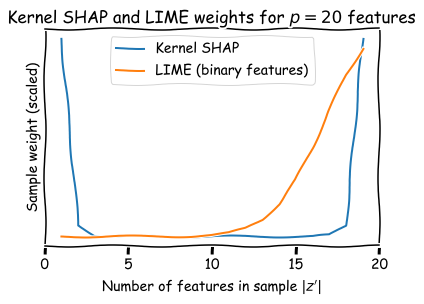

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.special import binom
plt.xkcd()

def shap_kernel(z, p):
    """ Kernel SHAP weights for z unmasked features among p"""
    return (p-1)/(binom(p, z)*(z*(p-z)))

def lime_kernel(z, p):
    """LIME kernel for binary input features """
    return np.exp(-(z-p)**2/p)
    
n_features = 20

x = list(range(1, n_features))
scaling_factor = shap_kernel(1, n_features)
plt.plot(x, [shap_kernel(z, n_features)/scaling_factor for z in x], label="Kernel SHAP")
plt.plot(x, [lime_kernel(z, n_features) for z in x], label="LIME (binary features)")
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([])
plt.title(f"Kernel SHAP and LIME weights for $p={n_features}$ features")
plt.xlabel("Number of features in sample $\\left|z^{\\prime}\\right|$")
plt.ylabel("Sample weight (scaled)")
plt.legend()
plt.show();

So, as expected the biggest difference between the Kernel SHAP and the LIME sample weighting strategies is seen when only a few features are present: LIME attributes a small weight to those samples because they are far from the datapoint being investigated, while Kernel SHAP attributes a large weight to it because it isolates the individual behavior of features.

Note that the weights for $\left|z^\prime\right|=0$ and $\left|z^\prime\right|=p$ are not represented because they are infinite! Those infinities ensure missingness ($z_i = 0 \Longrightarrow \phi_i = 0$, so $\phi_0 = f(\emptyset)$) and local accuracy ($\sum_i \phi_i = f(x)$) respectively. In practice, "[...] these infinite weights can be avoided during optimization by analytically eliminating two variables using these constraints." (the constraints being the missingness and local accuracy equations).

## Toy examples

In the following of this post I'll simply reproduce the computation SHAP attributions step-by-step on toy examples, starting with the one-dimensional case and moving on to the two-dimensional one.

## One dimension

The one-dimensional case is trivial: as mentioned above the infinite weights for coalitions involving no features or all of them impose two constraints:

$$\phi_0 = f(\emptyset)$$
and
$$\sum_i \phi_i = \phi_0 + \phi_1 = f(x)$$

We can estimate $\phi_0$ as the average prediction of the model over all samples, such that the weight of the only variable is the difference of the model prediction and the average prediction: $\phi_1 = f(x) - \frac1N\sum_j f\left(x_j\right)$. 

Thus for a very simple model that predicts 0 for $x<0$ and 1 otherwise, the weight $\phi_1$  of the only feature is -0.5 for every data point below 0 and +0.5 above 0.

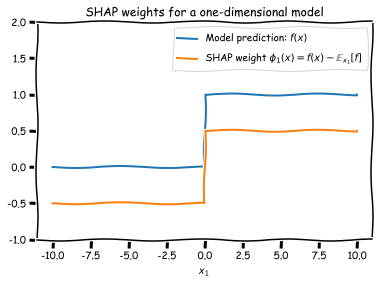

In [2]:
x = np.arange(-10, 10, 0.01)
predictions = [float(i > 0) for i in x]
plt.plot(x, predictions, label="Model prediction: $f(x)$")
plt.plot(x, [f-0.5 for f in predictions], label="SHAP weight $\phi_1(x)=f(x)-\mathbb{E}_{x_1}[f]$")
plt.ylim(-1, 2)
plt.title(f"SHAP weights for a one-dimensional model")
plt.xlabel("$x_1$")
plt.legend();

## Two dimensions

With two features we actually have to sample data points to estimate Shapley values with Kernel SHAP. As before the reference Shapley value $\phi_0$ is given by the average of the model over the dataset, and the infinite sample weight for the features coalition involving all features ($\pi_{x}^{\mathrm{SHAP}}\left(p\right)=\infty$) imposes the constraint mentioned above: $\phi_0 + \phi_1 + \phi_2 = f(x)$.

## Toy dataset creation
Let's create a "disk-shaped" dataset.

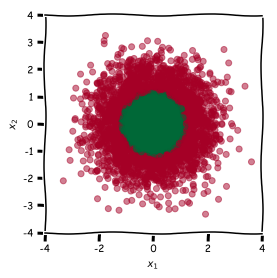

In [2]:
from sklearn.datasets import make_gaussian_quantiles

dataset = make_gaussian_quantiles(n_samples=5000, n_classes=2, random_state=2020)

x, y = dataset[0], 1-dataset[1]

plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.5, cmap="RdYlGn")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect(aspect=1.)

## Fit a model

Here I fit a small neural network since a linear model would of course not be able to reproduce the decision boundaries of our disk dataset. Note that an SVM would have been the best choice (or a linear model on smartly transformed features, e.g. $x_1 \rightarrow x_1^2+x_2^2$).

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
np.random.seed(2020)
tf.random.set_seed(2020)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)


def create_model():
    """ Model creation function: returns a compiled MLP"""
    model = Sequential()
    model.add(Dense(10, activation='tanh', name="hidden", input_dim=2))
    model.add(Dense(1, activation='sigmoid', name="output"))
    model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
    return model

neural_net = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

neural_net.fit(x_train, y_train)

print(f"Accuracy: {neural_net.score(x_test, y_test):.3f}")

Accuracy: 0.982


## Plot the decision boundary

Model score for the prediction to be explained: f(1.3, 0.0)=0.231


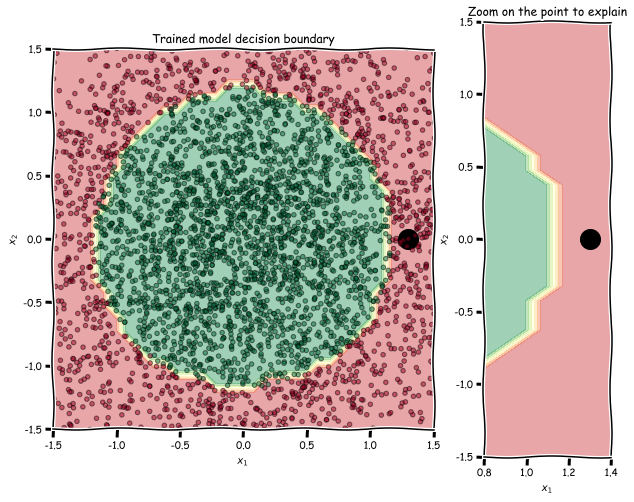

In [4]:
x_explain = (1.3, 0.)

x_explain_prediction = neural_net.predict_proba(np.array([x_explain]))[:, 1][0]
print(f"Model score for the prediction to be explained: f{x_explain}={x_explain_prediction:.3f}")
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [3, 1]})

Z = neural_net.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

for ax in axarr:
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    
axarr[0].scatter(x[:, 0], x[:, 1], c=y, s=20, alpha = 0.5, edgecolor='k', cmap="RdYlGn")
axarr[0].set_title("Trained model decision boundary")
axarr[0].set_xlim(-1.5, 1.5)
axarr[0].set_ylim(-1.5, 1.5)
axarr[0].set_aspect(aspect=1.)

axarr[1].set_title("Zoom on the point to explain")
axarr[1].set_xlim(0.8, 1.4)
axarr[1].set_ylim(-1.5, 1.5)
plt.show()

## SHAP samples

At this point a crucial assumption is made in the SHAP paper: feature independence. This assumption corresponds to the step from equation (10) to equation (11) in the paper 
$$E_{z_{\bar{S}} | z_{S}}[f(z)] \approx E_{z_{\bar{S}}}[f(z)],$$ 

and is equivalent to assuming that the impact of adding a variable to a coalition is always the same not matter what is the initial coalition.

This assumption greatly simplifies the problem because it gives a recipe for the computation of the model prediction with missing values. In our 2-dimensional problem we simply have to compute the average prediction of the model with one fixed and the other one varying over the samples, and do the same for the other variable:

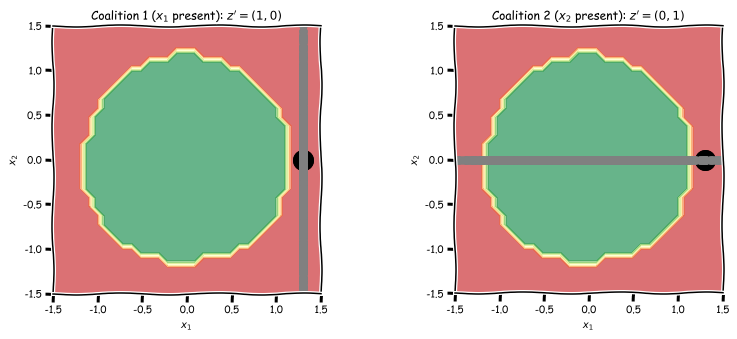

In [5]:
np.random.seed(2020)
n_samples = 1000

x1_present = np.column_stack((np.full(n_samples, x_explain[0]), np.random.randn(n_samples)))
x2_present = np.column_stack((np.random.randn(n_samples), np.full(n_samples, x_explain[1])))
shap_samples = np.concatenate((x1_present, x2_present))

f, axarr = plt.subplots(1, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.5)

for i, ax in enumerate(axarr):
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    if i == 0:
        ax.scatter([x_explain[0]]*len(shap_samples[:, 1]), [shap_samples[:, 1]], c="grey", alpha=1., s=50)
        ax.set_title("Coalition 1 ($x_1$ present): $z^\prime=(1, 0)$")
    else:
        ax.scatter([shap_samples[:, 0]], [x_explain[1]]*len(shap_samples[:, 0]), c="grey", alpha=1., s=50)
        ax.set_title("Coalition 2 ($x_2$ present): $z^\prime=(0, 1)$")

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect(1.)
    
plt.show()

Remember that we only have to determine one Shapley value, the other two being fully determined by the $\pi_{x}^{\mathrm{SHAP}}\left(0\right)=\infty$ and $\pi_{x}^{\mathrm{SHAP}}\left(p\right)=\infty$ constraints.

In [6]:
f_x1_present = neural_net.predict_proba(x1_present)[:, 1]
print(f"Average model prediction with only $x_1$ fixed (to 1.3): f(1.3, .)={f_x1_present.mean():.3f}")
f_x2_present = neural_net.predict_proba(x2_present)[:, 1]
print(f"Average model prediction with only $x_2$ fixed (to 0): f(., 0)={f_x2_present.mean():.3f}")

Average model prediction with only $x_1$ fixed (to 1.3): f(1.3, .)=0.140
Average model prediction with only $x_2$ fixed (to 0): f(., 0)=0.762


Going back to SHAP sample figure, the first value is the average of the model prediction over the vertical line, and the second value is the same average over the horizontal line.

In our 2-dimensional example, we're simply trying to find $\phi_1$ and $\phi_2$ such that we minimize the *fidelity function*

$$ \begin{align}
L\left(f, g, \pi_{x}\right)&=\sum_{z^{\prime} \in Z}\left[f\left(h_{x}\left(z^{\prime}\right)\right)-g\left(z^{\prime}\right)\right]^{2} \pi_{x}\left(z^{\prime}\right)\\
            &= \frac12 \left [ \mathbb E_{z_2} f(x_1, z_2) - (\phi_0 + \phi_1)\right]^2 + \frac12 \left [ \mathbb E_{z_1} f(z_1, x_2) - (\phi_0 + \phi_2)\right]^2
\end{align}.$$


We can rewrite this using the missingness constraint 
$$\mathbb{E} [f] = \phi_0$$

and the local accuracy one
$$f(x)=\sum\phi_i \Longleftrightarrow \phi_2=f(x)-\phi_0-\phi_1, $$
such that the fidelity reads:
$$ L\left(f, g, \pi_{x}\right) = \frac12 \left [ \left(\mathbb E_{z_2} f(x_1, z_2) - \mathbb E [f]\right) - \phi_1\right]^2 + \frac12 \left [ \left(\mathbb E_{z_1} f(z_1, x_2) - f(x) \right)+ \phi_1 \right]^2
.$$

Thus, we have to solve a linear regression problem with
$$ X = \begin{pmatrix}
1 \\
-1
\end{pmatrix} \qquad 
y= \begin{pmatrix}
\mathbb E_{z_2} f(x_1, z_2) - \mathbb{E} [f]\\
\mathbb E_{z_1} f(z_1, x_2) - f(x)
\end{pmatrix}, $$

i.e. a one-dimensional linear regression with two-samples! Piece of 🎂.

In [7]:
from sklearn.linear_model import LinearRegression

non_zero_z = np.array([1., 1.])  # Number of non-zero elements
sample_weights = shap_kernel(non_zero_z, 2)
phi0 = neural_net.predict_proba(x_train)[:, 1].mean()


X_shap = np.array([[1.], [-1.]])
y_shap = np.array([[f_x1_present.mean()-phi0], [f_x2_present.mean()-x_explain_prediction]])

solver = LinearRegression(fit_intercept=False)
solver.fit(X_shap, y_shap, sample_weight=sample_weights)
phi1 = solver.coef_[0][0]
phi2 = x_explain_prediction - phi0 - phi1
print(f"Results: \n\tphi0={phi0:.3f}, \n\tphi1={phi1:.3f}, \n\tphi2={phi2:.3f}")

Results: 
	phi0=0.509, 
	phi1=-0.450, 
	phi2=0.172


The interpretation of those results is the following: 
- The average of the model over the training set is 0.509
- The first feature $x_1$ has a weight close to -0.45, meaning that for similar examples with different values of $x_1$, the prediction of the model is much larger
- The second feature $x_2$ has a weight that is positive, such that this value is positively correlated with the prediction of the model for similar instances. 

Note that fitting $\phi_2$ instead of $\phi_1$ gives similar results, as expected.

## Using the SHAP package

In [8]:
from shap import KernelExplainer, initjs, force_plot

initjs()

sample = pd.DataFrame({"$x_1$": [x_explain[0]], "$x_2$": [x_explain[1]]})
labeled_x = pd.DataFrame(x, columns=["$x_1$", "$x_2$"])
explainer = KernelExplainer(neural_net.predict_proba, labeled_x.iloc[:50])

phi0 = explainer.expected_value[1]
print(f"Model average: $\phi_0={phi0:.3f}$")
shap_values = explainer.shap_values(sample, nsamples=10000, l1_reg=0., silent=True)[1]
print(f"Shapley values: $\phi_1={shap_values[0][0]:.3f}$, $\phi_2={shap_values[0][1]:.3f}$")

check = phi0 + sum(shap_values[0]) - x_explain_prediction
print(f"Sanity check (should be close to 0): $\sum_i \phi_i - f(x) = {check}$")
force_plot(phi0, shap_values[0,:], sample)

Model average: $\phi_0=0.517$
Shapley values: $\phi_1=-0.446$, $\phi_2=0.161$
Sanity check (should be close to 0): $\sum_i \phi_i - f(x) = 0.0$


The results are almost identical to ours, the small difference possibly being due to the different solver (hand-written normal equations for SHAP), and a slightly different evaluation of the model average predictions. (see [the code on GitHub](https://github.com/slundberg/shap/blob/73591d9a4d378284426bbfb89ef5e2092d2c9327/shap/explainers/kernel.py#L604) for details about the implementation).

## Comparison with LIME

In [23]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    x, feature_names=["x1", "x2"], class_names=["negative", "positive"], discretize_continuous=False
)
explanation = lime_explainer.explain_instance(np.array(x_explain), neural_net.predict_proba)
explanation.show_in_notebook()

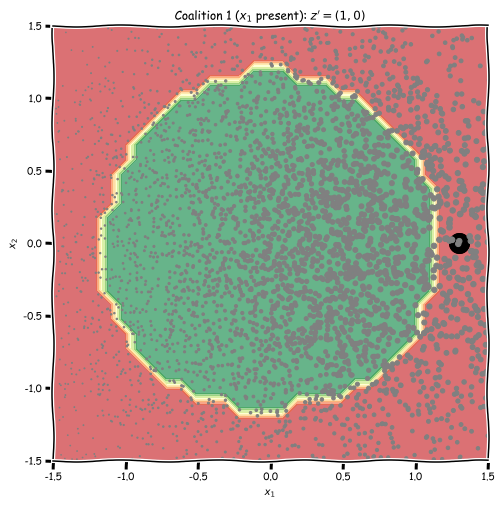

In [55]:
lime_samples = explanation.scaled_data
distances = np.linalg.norm(lime_samples - np.array([[x_explain[0], x_explain[1]] for i in range(len(lime_samples))]), axis=1)
weights = lime_explainer.base.kernel_fn(distances)

f, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)

ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
ax.scatter(lime_samples[:, 0], lime_samples[:, 1], c="grey", alpha=1., s=30*weights)
ax.set_title("Coalition 1 ($x_1$ present): $z^\prime=(1, 0)$")

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect(1.)
    
plt.show()

## Moons

In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

n_samples = 1500
x, y = datasets.make_moons(n_samples=n_samples, noise=.05)

plt.title("Moons", size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y) + 1))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[y])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
np.random.seed(2020)
tf.random.set_seed(2020)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)


def create_model():
    """ Model creation function: returns a compiled MLP"""
    model = Sequential()
    model.add(Dense(16, activation='relu', name="hidden_1", input_dim=2))
    model.add(Dense(16, activation='relu', name="hidden_2"))
    model.add(Dense(1, activation='sigmoid', name="output"))
    model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
    return model

neural_net = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

neural_net.fit(x_train, y_train)

print(f"Accuracy: {neural_net.score(x_test, y_test):.3f}")

In [ ]:
x_explain = (0., 0.5)

x_explain_prediction = neural_net.predict_proba(np.array([x_explain]))[:, 1][0]
print(f"Model score for the prediction to be explained: f{x_explain}={x_explain_prediction:.3f}")
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [3, 1]})

Z = neural_net.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

for ax in axarr:
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    
axarr[0].scatter(x[:, 0], x[:, 1], c=y, s=20, alpha = 0.5, edgecolor='k', cmap="RdYlGn")
axarr[0].set_title("Trained model decision boundary")
axarr[0].set_xlim(-1.5, 1.5)
axarr[0].set_ylim(-1.5, 1.5)
axarr[0].set_aspect(aspect=1.)

axarr[1].set_title("Zoom on the point to explain")
axarr[1].set_xlim(-0.5, 0.5)
axarr[1].set_ylim(-1.5, 1.5)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.special import binom

def shap_kernel(z, p):
    """ Kernel SHAP weights for z unmasked features among p"""
    return (p-1)/(binom(p, z)*(z*(p-z)))

non_zero_z = np.array([1., 1.])  # Number of non-zero elements
sample_weights = shap_kernel(non_zero_z, 2)
phi0 = neural_net.predict_proba(x_train)[:, 1].mean()

np.random.seed(2020)
n_samples = 1000

x1_present = np.column_stack((np.full(n_samples, x_explain[0]), np.random.randn(n_samples)))
x2_present = np.column_stack((np.random.randn(n_samples), np.full(n_samples, x_explain[1])))
shap_samples = np.concatenate((x1_present, x2_present))

f_x1_present = neural_net.predict_proba(x1_present)[:, 1]
print(f"Average model prediction with only $x_1$ fixed = {f_x1_present.mean():.3f}")
f_x2_present = neural_net.predict_proba(x2_present)[:, 1]
print(f"Average model prediction with only $x_2$ fixed = {f_x2_present.mean():.3f}")

X_shap = np.array([[1.], [-1.]])
y_shap = np.array([[f_x1_present.mean()-phi0], [f_x2_present.mean()-x_explain_prediction]])

solver = LinearRegression(fit_intercept=False)
solver.fit(X_shap, y_shap, sample_weight=sample_weights)
phi1 = solver.coef_[0][0]
phi2 = x_explain_prediction - phi0 - phi1
print(f"Results: \n\tphi0={phi0:.3f}, \n\tphi1={phi1:.3f}, \n\tphi2={phi2:.3f}")

In [ ]:
from shap import KernelExplainer, initjs, force_plot
import pandas as pd

initjs()

sample = pd.DataFrame({"$x_1$": [x_explain[0]], "$x_2$": [x_explain[1]]})
labeled_x = pd.DataFrame(x, columns=["$x_1$", "$x_2$"])
explainer = KernelExplainer(neural_net.predict_proba, labeled_x.iloc[:50])

phi0 = explainer.expected_value[1]
print(f"Model average: $\phi_0={phi0:.3f}$")
shap_values = explainer.shap_values(sample, nsamples=10000, l1_reg=0., silent=True)[1]
print(f"Shapley values: $\phi_1={shap_values[0][0]:.3f}$, $\phi_2={shap_values[0][1]:.3f}$")
# force_plot(phi0, shap_values[0,:], sample)

In [ ]:
import lime
import lime.lime_tabular

lime_explainer = explainer = lime.lime_tabular.LimeTabularExplainer(x, feature_names=["x1", "x2"], class_names=["negative", "positive"], discretize_continuous=False)
explanation = lime_explainer.explain_instance(np.array(x_explain), neural_net.predict_proba, num_features=2, top_labels=1)
explanation.show_in_notebook(show_table=True, show_all=False)

## Conclusion

We've presented the machine learning model interpretation problem on a toy example, highlighted the shortcomings of a naive approach, the improvements of using Shapley values... and the unfortunate intractability. 

The SHAP paper introduces a set of three desirable properties of feature attribute methods plus several techniques to efficiently estimate feature attributions. I've focused on KernelSHAP here because it is the most versatile of those methods, but DeepSHAP and TreeSHAP are even better for the eponym models, the first one being more efficient and the second one being exact and fast!

Note that the two-dimensional version of KernelSHAP that we have derived is easily generalized to larger dimensions: one simply has to write the fidelity function 

$$L\left(f, g, \pi_{x}\right)=\sum_{z^{\prime} \in Z}\left[f\left(h_{x}\left(z^{\prime}\right)\right)-g\left(z^{\prime}\right)\right]^{2} \pi_{x}\left(z^{\prime}\right)$$

for all coalitions $z^\prime$ and replace $\phi_0$ with the average of $f$, and $\phi_p$ with $f(x)-\sum_{i=0}^{p-1}\phi_i$. It results in a $p-1$-dimensional linear regression problem with a number of examples that is equal to the number of possible coalitions $p!$.

I hope SHAP is a bit less mysterious now, do not hesitate to play with the package and the various visualizations it offers. You can also compare it with other equivalent methods (LIME, Integrated gradients, ...) to make your own mind regarding the relevance of the method. I personally like the fact that the authors provide a set of desirable properties and build methods with those constraints in mind. Let me know what you think in the comments!